In [ ]:
#%pip install keras
#%pip install tensorflow

In [6]:
import numpy as np
import pandas as pd
# import seaborn as sns
from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow.keras.utils import plot_model


from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model


#https://www.tensorflow.org/tutorials/quickstart/advanced

In [7]:
# Importamos el modelo de keras datasets Minst para facilitar el acceso y la lectura de datos
mnist = tf.keras.datasets.mnist

#Descargamos los datos de la database y realizamos las transformaciones y las normalizaciones pertienentes. 
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

# Incluimos una nueva dimension a nuestro dataset. 
X_train = X_train[..., tf.newaxis].astype("float32")
X_test = X_test[..., tf.newaxis].astype("float32")

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test= tf.convert_to_tensor(X_test, dtype=tf.float32)


#y_train = keras.utils.to_categorical(y_train, 10)
#y_test = keras.utils.to_categorical(y_test, 10)


# Creamos la función que adapta los datos.

def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

# Convertimos los datos al formato que posteriormente necesitaremos.
X_train = to_rgb(X_train)
X_test = to_rgb(X_test)

#Comprobamos que se ha incluido correctamente la nueva dimension a nuestro dataset. 
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 3)
(10000, 28, 28, 3)


In [8]:

#Se asemeja al Dataloader de Pytorch, transforamos a Tensor y realizamos los batches. 
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [9]:
#Implementaciocon de duestra red neuronal 
class KerasNeuronal(keras.Model):
  def __init__(self):
    super(KerasNeuronal, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu', input_shape=(28,28,3))
    self.max1 = MaxPooling2D((2, 2))
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.max1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = KerasNeuronal()

# Llamamos las instancias de la funcion de perdida y los optimizadores. 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD()


# Asi podemos guardar el modelo
model.compile(optimizer=optimizer, loss=loss_object)


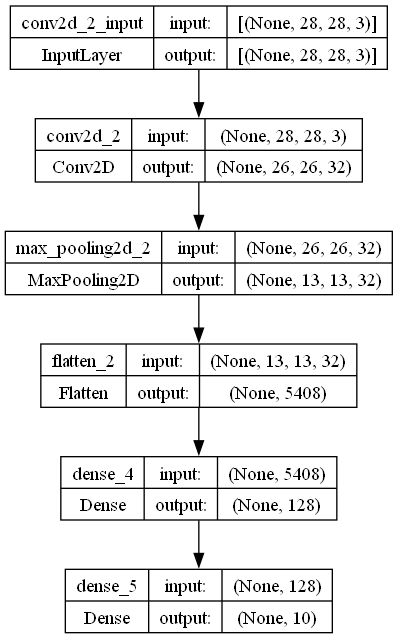

In [11]:

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

# Crear una instancia del modelo
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(28, 28, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10)
])

# Compilar el modelo con función de pérdida y optimizador
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Visualizar y guardar la arquitectura del modelo
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)



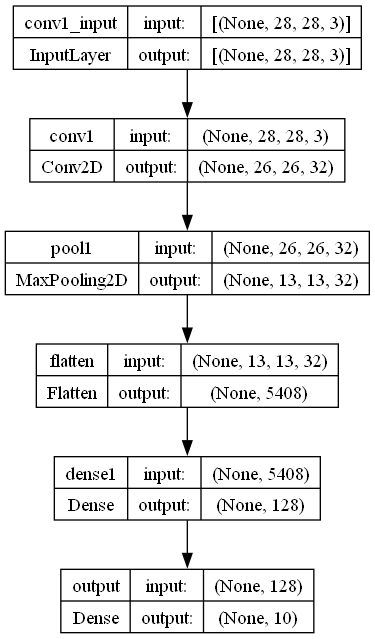

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

# Crear una instancia del modelo
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(28, 28, 3), name='conv1'),
    MaxPooling2D((2, 2), name='pool1'),
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='dense1'),
    Dense(10, name='output')
], name='my_model')  # Puedes asignar un nombre al modelo también

# Compilar el modelo con función de pérdida y optimizador
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Visualizar y guardar la arquitectura del modelo
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [15]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [16]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [17]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [18]:
EPOCHS = 10

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}')

Epoch 1, Loss: 0.36688128113746643, Accuracy: 89.51000213623047, Test Loss: 0.19357357919216156, Test Accuracy: 94.33000183105469
Epoch 2, Loss: 0.1754193753004074, Accuracy: 94.8116683959961, Test Loss: 0.1373962014913559, Test Accuracy: 95.79000091552734
Epoch 3, Loss: 0.12805043160915375, Accuracy: 96.13166809082031, Test Loss: 0.10687927156686783, Test Accuracy: 96.69999694824219
Epoch 4, Loss: 0.10312161594629288, Accuracy: 96.89166259765625, Test Loss: 0.08803829550743103, Test Accuracy: 97.37999725341797
Epoch 5, Loss: 0.08538667112588882, Accuracy: 97.48332977294922, Test Loss: 0.08153221011161804, Test Accuracy: 97.33999633789062
Epoch 6, Loss: 0.07361184060573578, Accuracy: 97.7933349609375, Test Loss: 0.07090182602405548, Test Accuracy: 97.70999908447266
Epoch 7, Loss: 0.06482398509979248, Accuracy: 98.01166534423828, Test Loss: 0.06760241091251373, Test Accuracy: 97.89999389648438
Epoch 8, Loss: 0.057454805821180344, Accuracy: 98.28666687011719, Test Loss: 0.068216525018215

## Guardado del modelo

In [19]:
# Save the weights
model.save_weights('cnn_weights.h5')
model.save('trained_model/')

INFO:tensorflow:Assets written to: trained_model/assets


INFO:tensorflow:Assets written to: trained_model/assets
